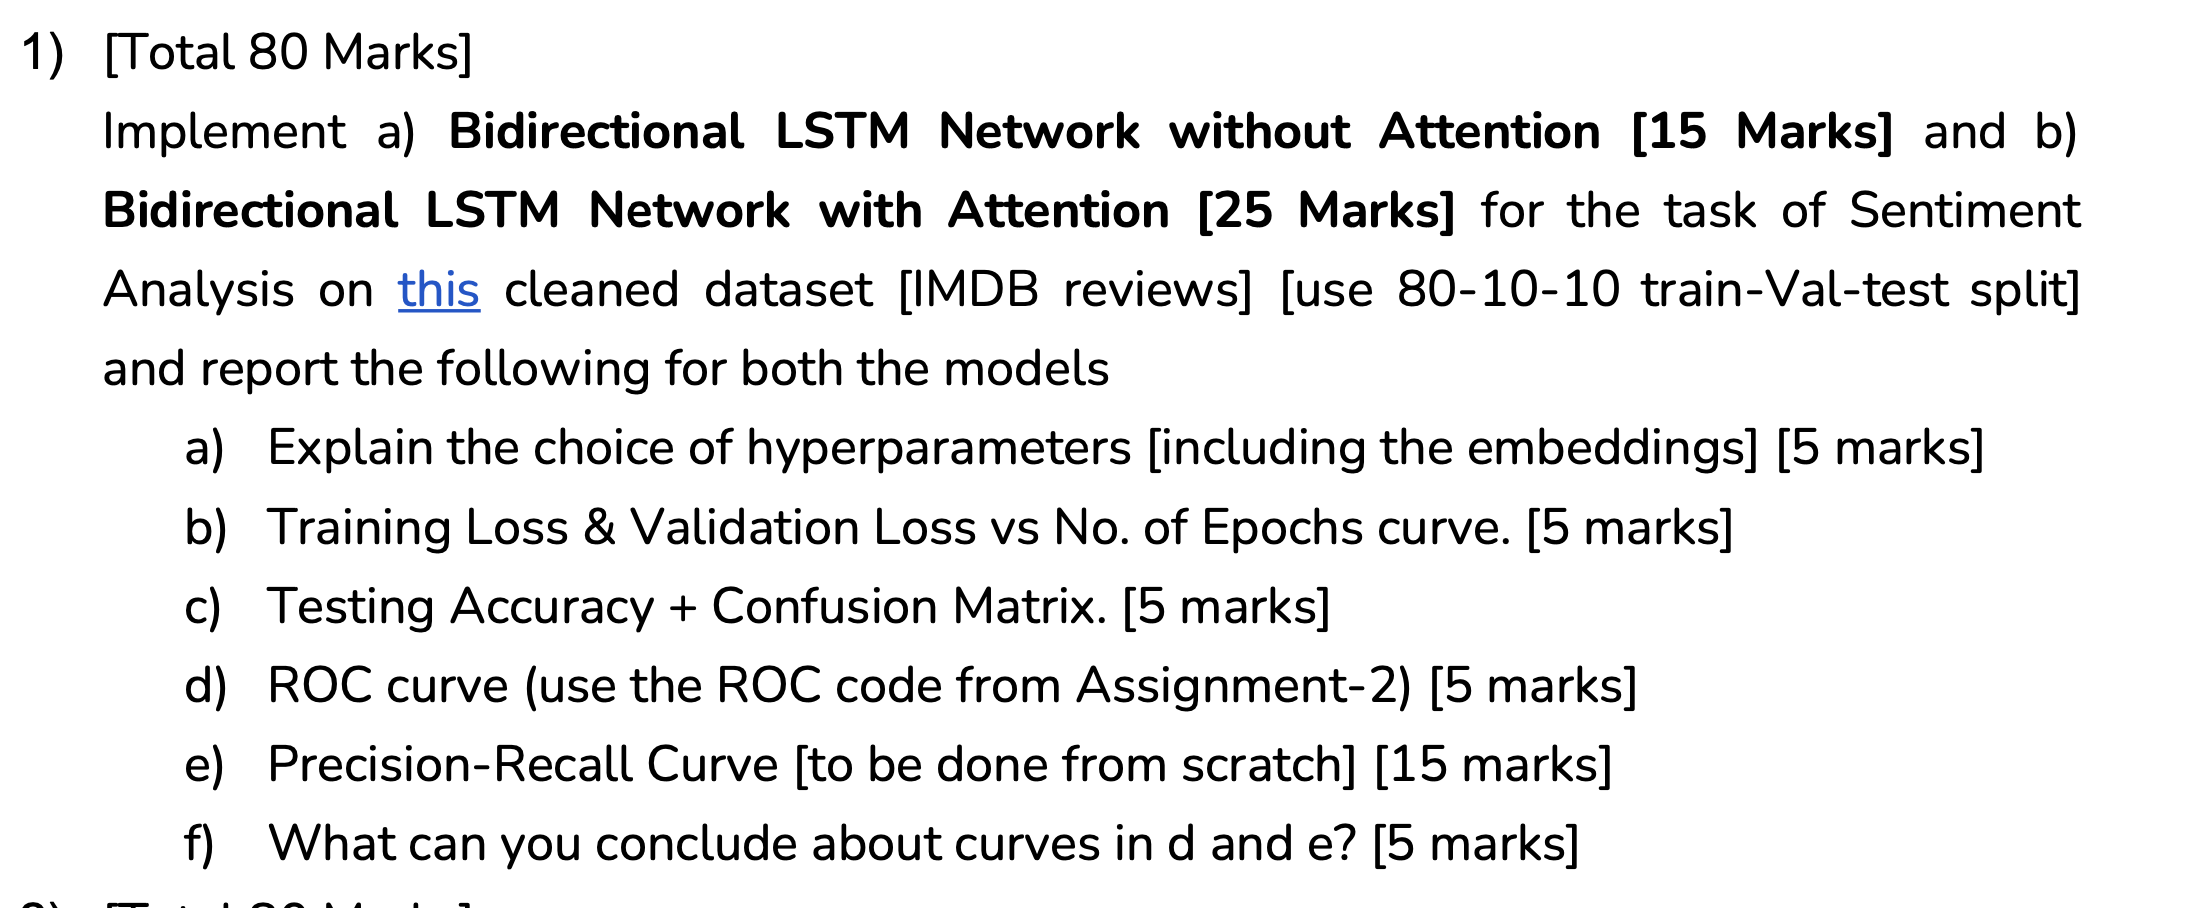

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchtext import data, datasets
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import math
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
torch.backends.cudnn.deterministic = True
def get_deivce():
	return 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:

def load_data(batch_size):
	SEED = 99

	torch.manual_seed(SEED)
	torch.cuda.manual_seed(SEED)
	torch.backends.cudnn.deterministic = True

	TEXT = data.Field(tokenize='spacy')
	LABEL = data.LabelField(dtype=torch.float)
	train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
	train_data, valid_data = train_data.split(random_state=random.seed(SEED))

	TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.300d")
	LABEL.build_vocab(train_data)

	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
		(train_data, valid_data, test_data),
		batch_size=batch_size,
		device=device)

	return TEXT, LABEL, train_iterator, valid_iterator, test_iterator

batch_size = 32
TEXT, LABEL, train_iterator, valid_iterator, test_iterator = load_data(batch_size)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.2MB/s]
.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399776/400000 [00:37<00:00, 10546.37it/s]

In [3]:
class ModelNoAttention(nn.Module):

	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, d_rate):
		super(ModelNoAttention, self).__init__()
		self.embedding = nn.Embedding(vocab_size, embedding_dim)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,bidirectional=True,dropout=d_rate)
		self.dense = nn.Linear(2 * hidden_dim, output_dim)
		self.dropout = nn.Dropout(d_rate)

	def forward(self, x):
		# x: (sentence_length, batch_size)

		embedded = self.dropout(self.embedding(x))
		# embedded: (sentence_length, batch_size, embedding_dim)

		lstm_output, (hidden, c_n) = self.lstm(embedded)

		# gru_output: (sentence_length, batch_size, hidden_dim * 2)
		# hidden: (num_layers * 2, batch_size, hidden_dim)
		## ordered: [f_layer_0, b_layer_0, ...f_layer_n, b_layer n]

		# concat the final output of forward direction and backward direction
		hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
		# hidden: (batch_size, hidden_dim * 2)

		output = self.dense(hidden)

		return output

class Self_Attention(nn.Module):
	def __init__(self, query_dim):
		# assume: query_dim = key/value_dim
		super(Self_Attention, self).__init__()
		self.scale = 1. / math.sqrt(query_dim)

	def forward(self, query, key, value):
		# query == hidden: (batch_size, hidden_dim * 2)
		# key/value == gru_output: (sentence_length, batch_size, hidden_dim * 2)
		query = query.unsqueeze(1) # (batch_size, 1, hidden_dim * 2)
		key = key.transpose(0, 1).transpose(1, 2) # (batch_size, hidden_dim * 2, sentence_length)

		# bmm: batch matrix-matrix multiplication
		attention_weight = torch.bmm(query, key) # (batch_size, 1, sentence_length)
		attention_weight = F.softmax(attention_weight.mul_(self.scale), dim=2) # normalize sentence_length's dimension

		value = value.transpose(0, 1) # (batch_size, sentence_length, hidden_dim * 2)
		attention_output = torch.bmm(attention_weight, value) # (batch_size, 1, hidden_dim * 2)
		attention_output = attention_output.squeeze(1) # (batch_size, hidden_dim * 2)

		return attention_output, attention_weight.squeeze(1)


class ModelWithAttention(nn.Module):
	# model = Model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)

	def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, d_rate):
		super(ModelWithAttention, self).__init__()
		self.embedding = nn.Embedding(vocab_size, embedding_dim)
		# self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,bidirectional=True, dropout=d_rate)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,bidirectional=True,dropout=d_rate)
		self.dense = nn.Linear(2 * hidden_dim, output_dim)
		self.dropout = nn.Dropout(d_rate)
		self.attention = Self_Attention(2 * hidden_dim)

	def forward(self, x):
		# x: (sentence_length, batch_size)

		embedded = self.dropout(self.embedding(x))
		# embedded: (sentence_length, batch_size, embedding_dim)
		# gru_output, hidden = self.gru(embedded)
		lstm_output, (hidden, c_n) = self.lstm(embedded)
		# lstm_output: (sentence_length, batch_size, hidden_dim * 2)
		## depth_wise
		# hidden: (num_layers * 2, batch_size, hidden_dim)
		## ordered: [f_layer_0, b_layer_0, ...f_layer_n, b_layer n]

		# concat the final output of forward direction and backward direction
		hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
		# hidden: (batch_size, hidden_dim * 2)

		rescaled_hidden, attention_weight = self.attention(query=hidden, key=lstm_output, value=lstm_output)
		output = self.dense(rescaled_hidden)

		return output.squeeze(1), attention_weight

In [4]:

def train_run(model, iterator, optimizer, criterion, aflag):
  epoch_loss = 0
  epoch_acc = 0
  epoch_lossAll=[]
  model.train()
  if aflag is True:
    for index, batch in enumerate(iterator):
      # print(f'Now: {index} / {len(iterator)}')
      optimizer.zero_grad()
      output, _ = model(batch.text)
      # print('output',output.shape)
      loss = criterion(output, batch.label)
      acc = binary_accuracy(output, batch.label)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  else:
    for index, batch in enumerate(iterator):
      # print(f'Now: {index} / {len(iterator)}')
      optimizer.zero_grad()
      output = model(batch.text).squeeze(1)
      # print('output',size(output))
      loss = criterion(output, batch.label)
      acc = binary_accuracy(output, batch.label)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  epoch_lossAll.append(epoch_loss / len(iterator))
  return epoch_lossAll, epoch_loss / len(iterator), epoch_acc / len(iterator)


def eval_run(model, iterator, criterion, aflag):
  epoch_loss = 0
  epoch_acc = 0
  epoch_lossAll = []
  model.eval()

  with torch.no_grad():
    if aflag is True:
      for batch in iterator:
        predictions, _ = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    else:
      for batch in iterator:
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
  epoch_lossAll.append(epoch_loss / len(iterator))
  return epoch_lossAll, epoch_loss / len(iterator), epoch_acc / len(iterator)


def binary_accuracy(preds, y):
	rounded_preds = torch.round(torch.sigmoid(preds))
	correct = (rounded_preds == y).float() #convert into float for division
	acc = correct.sum() / len(correct)
	return acc

Part B

In [5]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
OUTPUT_DIM = 1
NUM_LAYERS = 3
DROPOUT = 0.4
N_EPOCHS = 5

# IMPORTANT PART TO SWITCH FOR ATTENTION OR NON ATTENTION MODEL

ATTN_FLAG = True
# ATTN_FLAG = False

model = ModelWithAttention(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)

# check the embedding vector
# pretrained_embeddings = TEXT.vocab.vectors
# print(pretrained_embeddings.shape)

# set an optimizer and a loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

# for a gpu environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)
train_lossAll=[]
valid_lossAll=[]
for epoch in range(N_EPOCHS):
  train_loss,train_loss, train_acc = train_run(model, train_iterator, optimizer, criterion, ATTN_FLAG)
  valid_loss,valid_loss, valid_acc = eval_run(model, valid_iterator, criterion, ATTN_FLAG)
  train_lossAll.append(train_loss)
  valid_lossAll.append(valid_loss)
  print(f' \nEpoch: {epoch+1:02} , Train Loss: {train_loss:.3f} , Train Acc: {train_acc*100:.2f}% , Val. Loss: {valid_loss:.3f} , Val. Acc: {valid_acc*100:.2f}% |')
torch.save(model.state_dict(), 'with_att_imdb.pt')


100%|█████████▉| 399776/400000 [00:50<00:00, 10546.37it/s]

 
Epoch: 01 , Train Loss: 0.653 , Train Acc: 58.61% , Val. Loss: 0.964 , Val. Acc: 61.11% |
 
Epoch: 02 , Train Loss: 0.470 , Train Acc: 76.92% , Val. Loss: 0.318 , Val. Acc: 86.79% |
 
Epoch: 03 , Train Loss: 0.274 , Train Acc: 88.91% , Val. Loss: 0.271 , Val. Acc: 89.48% |
 
Epoch: 04 , Train Loss: 0.206 , Train Acc: 91.98% , Val. Loss: 0.298 , Val. Acc: 89.87% |
 
Epoch: 05 , Train Loss: 0.150 , Train Acc: 94.22% , Val. Loss: 0.303 , Val. Acc: 89.99% |


[0.6529124871686346, 0.47027692961518464, 0.2743576412826395, 0.20617522900307744, 0.14968177865530063]


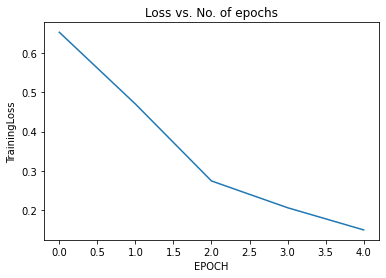

In [6]:
history = train_lossAll
print(history)
plt.plot(range(len(history)),history)
plt.xlabel("EPOCH")
plt.ylabel('TrainingLoss')
plt.title('Loss vs. No. of epochs');
plt.show()



[0.9636304245350209, 0.31805542361863115, 0.2714551132093085, 0.2982136841784132, 0.3026422312364299]


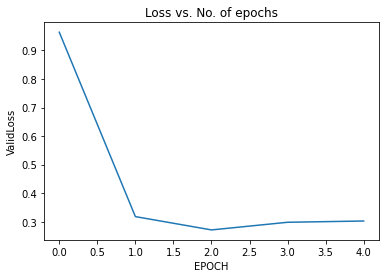

In [7]:
history = valid_lossAll
print(history)
plt.plot(range(len(history)),history)
plt.xlabel("EPOCH")
plt.ylabel('ValidLoss')
plt.title('Loss vs. No. of epochs');
plt.show()



In [8]:
model.load_state_dict(torch.load('with_att_imdb.pt'))
epoch_lossAll,test_loss, test_acc = eval_run(model, test_iterator, criterion, ATTN_FLAG)
print(f' Test Loss: {test_loss:.3f} , Test Acc: {test_acc*100:.2f}% ')
print('epoch_lossAll',epoch_lossAll)


 Test Loss: 0.337 , Test Acc: 88.87% 
epoch_lossAll [0.3374681646359222]


Part C

conf_matrix [[11515.   985.]
 [ 1797. 10703.]]
class_total [12500, 12500]
class_correct [11515, 10703]
Test Accuracy of   0: 92% (11515/12500)
Test Accuracy of   1: 85% (10703/12500)

Test Accuracy (Overall): 88% (22218/25000)
Ploting fig


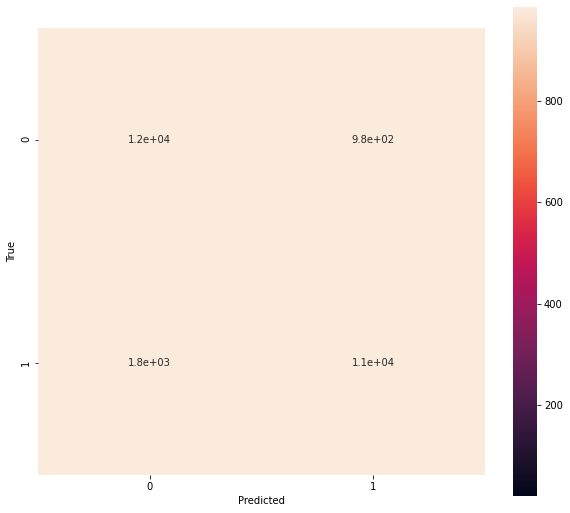

In [9]:
def PlotConfusionMatrix(model, test_iterator,aflag):
	class_total,class_correct,conf_matrix = computeConfMatrix(model, test_iterator,aflag)
	for i in range(2):
		if class_total[i] > 0:
			print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
				i, 100 * class_correct[i] / class_total[i],
				np.sum(class_correct[i]), np.sum(class_total[i])))

	print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
		100. * np.sum(class_correct) / np.sum(class_total),
		np.sum(class_correct), np.sum(class_total)))
	print("Ploting fig")
	plt.subplots(figsize=(10, 9))
	ax = sns.heatmap(conf_matrix,square=True ,annot=True, vmax=20)
	ax.set_xlabel('Predicted');
	ax.set_ylabel('True');
	plt.show()

import seaborn as sns
def computeConfMatrix(model, iterator,aflag):
  conf_matrix = np.zeros((2, 2))
  class_correct = [0] * 2
  class_total = [0] * 2
  model.eval()
  with torch.no_grad():
    if aflag is True:
      for batch in iterator:
        predictions, _ = model(batch.text)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct_tensor = rounded_preds.eq(batch.label.data.view_as(rounded_preds))
        correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(batch.label.size(0)):
          label = batch.label.data[i]
          label1=label.cpu().numpy()
          label2=label1.astype(int)
          class_correct[label2] += correct[i].item()
          class_total[label2] += 1
          label21=rounded_preds.data[i].cpu().numpy()
          label22=label21.astype(int)
          conf_matrix[label2,label22] = conf_matrix[label2,label22] + 1
    else:
      for batch in iterator:
        predictions = model(batch.text)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct_tensor = rounded_preds.eq(batch.label.data.view_as(rounded_preds))
        correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(batch.label.size(0)):
          label = batch.label.data[i]
          label1=label.cpu().numpy()
          label2=label1.astype(int)
          class_correct[label2] += correct[i].item()
          class_total[label2] += 1
          label21=rounded_preds.data[i].cpu().numpy()
          label22=label21.astype(int)
          conf_matrix[label2,label22] = conf_matrix[label2,label22] + 1
  print('conf_matrix',conf_matrix)
  print('class_total',class_total)
  print('class_correct',class_correct)
  return class_total,class_correct,conf_matrix
model.load_state_dict(torch.load('with_att_imdb.pt'))
PlotConfusionMatrix(model, test_iterator,ATTN_FLAG)

Part D

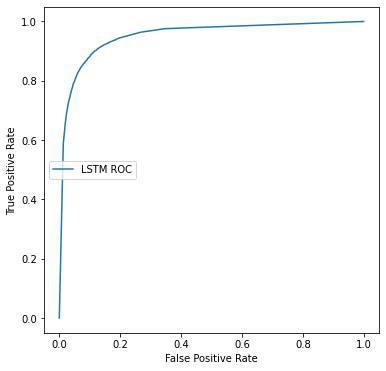

In [ ]:
def calc_TP_FP_rate(y_true, y_pred):

	TP = 0
	FP = 0
	TN = 0
	FN = 0

	# Determine whether each prediction is TP, FP, TN, or FN
	for i in range(len(y_true)):
		if y_true[i]==y_pred[i]==1:
		   TP += 1
		if y_pred[i]==1 and y_true[i]!=y_pred[i]:
		   FP += 1
		if y_true[i]==y_pred[i]==0:
		   TN += 1
		if y_pred[i]==0 and y_true[i]!=y_pred[i]:
		   FN += 1

	# Calculate true positive rate and false positive rate
	tpr = TP / (TP + FN)
	fpr = FP / (FP + TN)

	return tpr, fpr

lr_tp_rates = []
lr_fp_rates = []
# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
	y_test_preds = []
	for prob in preds:
		if prob > p:
			y_test_preds.append(1)
		else:
			y_test_preds.append(0)
	tp_rate, fp_rate = calc_TP_FP_rate(org, y_test_preds)

	lr_tp_rates.append(tp_rate)
	lr_fp_rates.append(fp_rate)

# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lr_fp_rates, lr_tp_rates, label='LSTM ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='center left');


Part E

preds [0.0021568143, 0.99849653, 0.03310916, 0.0029886742, 0.004677858, 0.011368117, 0.0022599278, 0.9748225, 0.00180985, 0.0021394233, 0.011167342, 0.9981243, 0.9981341, 0.06724783, 0.0029054044, 0.99892515, 0.99867344, 0.1273569, 0.005233894, 0.0030714937, 0.003717067, 0.0034047635, 0.0024881363, 0.0032678982, 0.2870926, 0.020399056, 0.9959268, 0.02567379, 0.9981858, 0.0033016047, 0.65973467, 0.4299341, 0.99721235, 0.994905, 0.9965036, 0.99659926, 0.002204982, 0.0022155577, 0.008131567, 0.19871989, 0.97438556, 0.99889237, 0.015590253, 0.97833335, 0.007123239, 0.85061014, 0.63028014, 0.002545352, 0.001697395, 0.003835157, 0.99896324, 0.0015554664, 0.0070077362, 0.0025607902, 0.9976695, 0.676121, 0.15568204, 0.002636932, 0.0055720597, 0.0013045178, 0.002162643, 0.9973984, 0.95583767, 0.99809986, 0.9988701, 0.0018796999, 0.0024405504, 0.0017417786, 0.0052660424, 0.0021457216, 0.0024246627, 0.002392836, 0.9980501, 0.0023506852, 0.99845374, 0.99383295, 0.9988574, 0.9885915, 0.9987833, 0.2

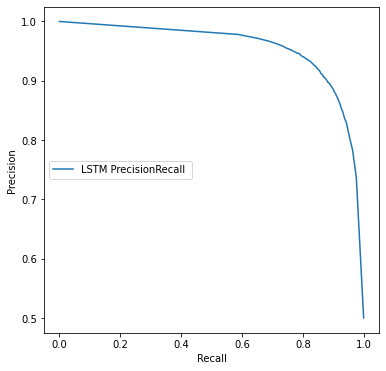

In [10]:

def computePrecRecallData (model, iterator,aflag):
	org = []
	prob = []
	model.eval()
	with torch.no_grad():
		if aflag is True:
			for batch in iterator:
				predictions, _ = model(batch.text)
				preds = torch.sigmoid(predictions)
				temp = np.squeeze(preds.detach().numpy()) if device == "cpu" else np.squeeze(preds.cpu().detach().numpy())
				prob.extend((temp))
				temp = np.squeeze(batch.label.detach().numpy()) if device == "cpu" else np.squeeze(batch.label.cpu().detach().numpy())
				org.extend(temp)

		else:
			for batch in iterator:
				predictions = model(batch.text)
				preds = torch.sigmoid(predictions)
				temp = np.squeeze(preds.detach().numpy()) if device == "cpu" else np.squeeze(preds.cpu().detach().numpy())
				prob.extend((temp))
				org.extend(batch.label)

	return prob,org
model.load_state_dict(torch.load('with_att_imdb.pt'))
preds, org=computePrecRecallData(model, test_iterator,ATTN_FLAG)
print('preds',preds)
print('org',org)

# Function to calculate Precision and Recall

def calc_precision_recall(y_true, y_pred):
	# Instantiate counters
	TP = 0
	FP = 0
	FN = 0
	# print('y_true',len(y_true))
	# print('y_pred',len(y_pred))
	# Determine whether each prediction is TP, FP, TN, or FN
	for i in range(len(y_true)):
		# print('y_true',y_true[i])
		# print('y_pred',y_pred[i])
		# print('i',i)
		if y_true[i]==y_pred[i]==1:
		   TP += 1
		if y_pred[i]==1 and y_true[i]!=y_pred[i]:
		   FP += 1
		if y_pred[i]==0 and y_true[i]!=y_pred[i]:
		   FN += 1

	# Calculate true positive rate and false positive rate
	# Use try-except statements to avoid problem of dividing by 0
	try:
		precision = TP / (TP + FP)
	except:
		precision = 1

	try:
		recall = TP / (TP + FN)
	except:
		recall = 1

	return precision, recall

# Containers for true positive / false positive rates
precision_scores = []
recall_scores = []
# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)
# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
	y_test_preds = []
	for prob in preds:
		if prob > p:
			y_test_preds.append(1)
		else:
			y_test_preds.append(0)
	precision, recall = calc_precision_recall(org, y_test_preds)
	precision_scores.append(precision)
	recall_scores.append(recall)
# Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='LSTM PrecisionRecall ')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');